In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, log_loss

import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_class_weights
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
from xception import Xception, preprocess_input

Using TensorFlow backend.


# Create data iterators

In [3]:
data_dir = '/home/ubuntu/data/'

In [4]:
data_generator = ImageDataGenerator(
    rotation_range=30, 
    zoom_range=0.3,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.001,
    channel_shift_range=0.1,
    fill_mode='reflect',
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

data_generator_val = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

train_generator = data_generator.flow_from_directory(
    data_dir + 'train_no_resizing', 
    target_size=(299, 299),
    batch_size=64
)

val_generator = data_generator_val.flow_from_directory(
    data_dir + 'val', shuffle=False,
    target_size=(299, 299),
    batch_size=64
)

Found 16980 images belonging to 256 classes.
Found 5120 images belonging to 256 classes.


# Model

In [48]:
model = Xception(weight_decay=1e-4)

for layer in model.layers[:-10]:
        layer.trainable = False

# Train

In [49]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_generator.class_indices)

In [50]:
model.compile(
    optimizer=optimizers.SGD(momentum=0.9, nesterov=True), 
    loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [51]:
from learning_rate_scheduler import LearningRateScheduler, cyclic_cosine_annealing

In [52]:
epochs = 10
steps_per_epoch = 266
T = steps_per_epoch*epochs
M = 1
initial = 0.01

In [ ]:
model.fit_generator(
    train_generator, 
    steps_per_epoch, epochs, verbose=1,
    callbacks=[LearningRateScheduler(lambda step: cyclic_cosine_annealing(step, initial, T, M))],
    validation_data=val_generator, validation_steps=80, workers=4,
    class_weight={i: j for i, j in enumerate(w/w.sum())}
)

Epoch 1/10
265/266 [============================>.] - ETA: 0s - loss: 0.8843 - acc: 0.0035 - top_k_categorical_accuracy: 0.0190

In [ ]:
# 0.5_0.5 1e-6 RMSprop_1e-3 -> loss: 0.5515 - acc: 0.8595 - top_k_categorical_accuracy: 0.9678 - val_loss: 0.7936 - val_acc: 0.8268 - val_top_k_categorical_accuracy: 0.9434
# 0.5_0.5 1e-4 1e-3 ->

In [54]:
for layer in model.layers[-10:]:
        layer.trainable = True

In [55]:
model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
    loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [56]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=266, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=3, epsilon=0.007),
        EarlyStopping(monitor='val_acc', patience=5, min_delta=0.01)
    ],
    validation_data=val_generator, validation_steps=80, workers=4,
    class_weight=w
)

Epoch 1/30
266/266 [==============================] - 160s - loss: 0.7926 - acc: 0.8063 - top_k_categorical_accuracy: 0.9401 - val_loss: 0.7621 - val_acc: 0.8064 - val_top_k_categorical_accuracy: 0.9424
Epoch 2/30
266/266 [==============================] - 158s - loss: 0.6924 - acc: 0.8292 - top_k_categorical_accuracy: 0.9494 - val_loss: 0.7233 - val_acc: 0.8189 - val_top_k_categorical_accuracy: 0.9473
Epoch 3/30
266/266 [==============================] - 158s - loss: 0.6246 - acc: 0.8425 - top_k_categorical_accuracy: 0.9582 - val_loss: 0.7020 - val_acc: 0.8227 - val_top_k_categorical_accuracy: 0.9492
Epoch 4/30
 80/266 [========>.....................] - ETA: 83s - loss: 0.5744 - acc: 0.8525 - top_k_categorical_accuracy: 0.9637

KeyboardInterrupt: 

# Loss/epoch plots

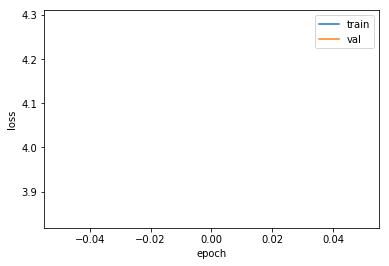

In [9]:
plt.plot(model.history.history['loss'], label='train');
plt.plot(model.history.history['val_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

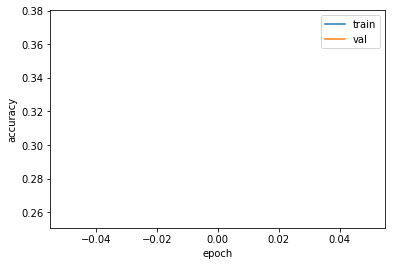

In [10]:
plt.plot(model.history.history['acc'], label='train');
plt.plot(model.history.history['val_acc'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

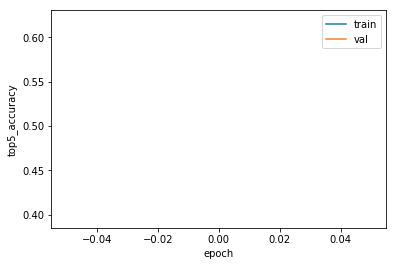

In [11]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Error analysis

### get human readable class names

In [12]:
# index to class name
decode = {val_generator.class_indices[k]: decode[int(k)] for k in val_generator.class_indices}

### get all predictions and all misclassified images 

In [13]:
val_predictions = [] 
val_true_targets = [] 
# erroneous_samples = [] 
# erroneous_targets = [] 
# erroneous_predictions = [] 

for i, (x_batch, y_batch) in enumerate(val_generator, 1):
    preds = model.predict_on_batch(x_batch)
    
    val_predictions += [preds]
    val_true_targets += [y_batch.argmax(1)]
    
#     miss = y_batch.argmax(1) != preds.argmax(1)
#     erroneous_samples += [x_batch[miss]]
#     erroneous_targets += [y_batch.argmax(1)[miss]]
#     erroneous_predictions += [preds[miss]]
    
    if i >= 80:
        break
    
val_predictions = np.concatenate(val_predictions, axis=0)
val_true_targets = np.concatenate(val_true_targets, axis=0)
# erroneous_samples = np.concatenate(erroneous_samples, axis=0)
# erroneous_targets = np.concatenate(erroneous_targets, axis=0)
# erroneous_predictions = np.concatenate(erroneous_predictions, axis=0)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

### number of misclassified images (there are overall 5120 images in the val dataset)

In [14]:
n_errors = len(erroneous_targets)
n_errors

2380

### logloss and accuracies

In [15]:
log_loss(val_true_targets, val_predictions)

2.755920841440286

In [16]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.53515625

In [17]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.66679687499999996, 0.72402343749999998, 0.7568359375, 0.78652343749999998, 0.86386718750000002]


### entropy of predictions

In [18]:
hits = val_predictions.argmax(1) == val_true_targets

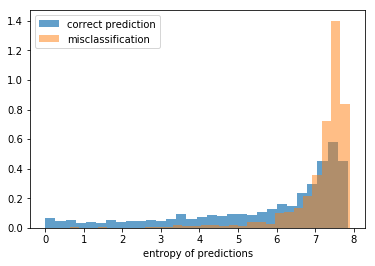

In [19]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

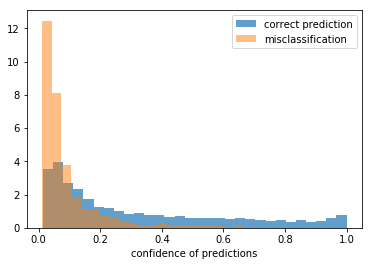

In [20]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

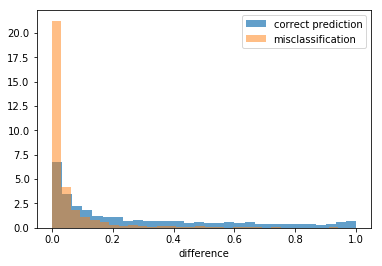

In [21]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

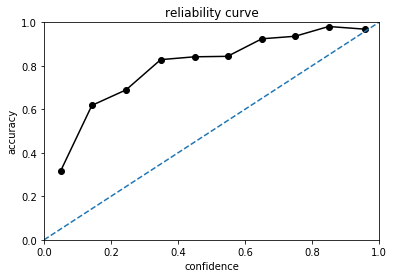

In [22]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

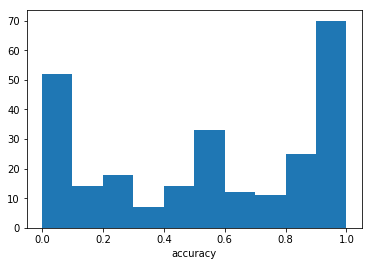

In [23]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [24]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

harpsichord 0.0
steering-wheel 0.0
jesus-christ 0.0
brain 0.0
chopsticks 0.0
smokestack 0.0
pez-dispenser 0.0
fighter-jet 0.0
playing-card 0.0
duck 0.0
skateboard 0.0
pram 0.0
pyramid 0.0
roulette-wheel 0.0
rifle 0.0


### class accuracy vs. number of samples in the class

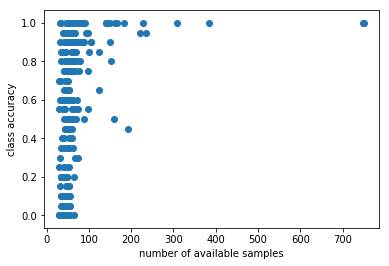

In [25]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [26]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('ak47', 'rifle'),
 ('head-phones', 'steering-wheel'),
 ('head-phones', 'stirrups'),
 ('head-phones', 'computer-mouse'),
 ('head-phones', 'eyeglasses'),
 ('helicopter', 'airplanes'),
 ('hibiscus', 'iris'),
 ('hibiscus', 'sunflower'),
 ('homer-simpson', 'superman'),
 ('horse', 'kangaroo'),
 ('horse', 'unicorn'),
 ('horse', 'greyhound'),
 ('horse', 'camel'),
 ('horse', 'dog'),
 ('horse', 'elk'),
 ('horse', 'giraffe'),
 ('horse', 'goat'),
 ('horseshoe-crab', 'mussels'),
 ('horseshoe-crab', 'cockroach'),
 ('hot-dog', 'hamburger'),
 ('billiards', 'coffin'),
 ('billiards', 'harpsichord'),
 ('human-skeleton', 'hammock'),
 ('jesus-christ', 'people'),
 ('binoculars', 'megaphone'),
 ('binoculars', 'boxing-glove'),
 ('binoculars', 'theodolite'),
 ('binoculars', 'top-hat'),
 ('binoculars', 'tripod'),
 ('binoculars', 'welding-mask'),
 ('binoculars', 'flashlight'),
 ('kangaroo', 'llama'),
 ('knife', 'swiss-army-knife'),
 ('ladder', 'menorah'),
 ('ladder', 'skyscraper'),
 ('ladder', 'basketball-hoop

# Save

In [ ]:
model.save_weights('xception_weights.hdf5')